In [ ]:
import pandas as pd
import numpy as np
import nltk
import pickle
import spacy
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pyproj
import re
import matplotlib.cm as cm
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
#Read file
df = pd.read_csv("/content/dataRad.csv")

print(df.shape)
df.head(5)

(5065, 2)


Report  BIRADS
0  Digital Mammography, Tomosynthesis and Bilater...       2
1  Digital Mammography, Tomosynthesis (3D) and Bi...       2
2  Digital Mammography, Tomosynthesis (3D) and Bi...       2
3  Digital Mammography with Tomosynthesis (3D) an...       3
4  Digital Mammography, Tomosynthesis (3D) and Bi...       2

In [ ]:

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [ ]:
df['preprocessed_txt'] = df['Report'].apply(preprocess)

In [ ]:
df

Report  BIRADS  \
0     Digital Mammography, Tomosynthesis and Bilater...       2   
1     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
2     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
3     Digital Mammography with Tomosynthesis (3D) an...       3   
4     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
...                                                 ...     ...   
5060  Digital Mammography, Tomosynthesis and Bilater...       2   
5061  Digital Mammography, Tomosynthesis (3D) and Bi...       3   
5062  Digital Mammography, Tomosynthesis and Bilater...       2   
5063  Digital Mammography, Tomosynthesis and Bilater...       3   
5064  Digital Mammography, Tomosynthesis (3D) and Bi...       2   

                                       preprocessed_txt  
0     Digital Mammography Tomosynthesis Bilateral Br...  
1     Digital Mammography Tomosynthesis 3D Bilateral...  
2     Digital Mammography Tomosynthesis 3D Bilateral...  
3     Digital Mammography Tomosynthesis 3D Bilateral...  
4     Digital Mammography Tomosynthesis 3D Bilateral...  
...                                                 ...  
5060  Digital Mammography Tomosynthesis Bilateral Br...  
5061  Digital Mammography Tomosynthesis 3D Bilateral...  
5062  Digital Mammography Tomosynthesis Bilateral Br...  
5063  Digital Mammography Tomosynthesis Bilateral Br...  
5064  Digital Mammography Tomosynthesis 3D Bilateral...  

[5065 rows x 3 columns]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

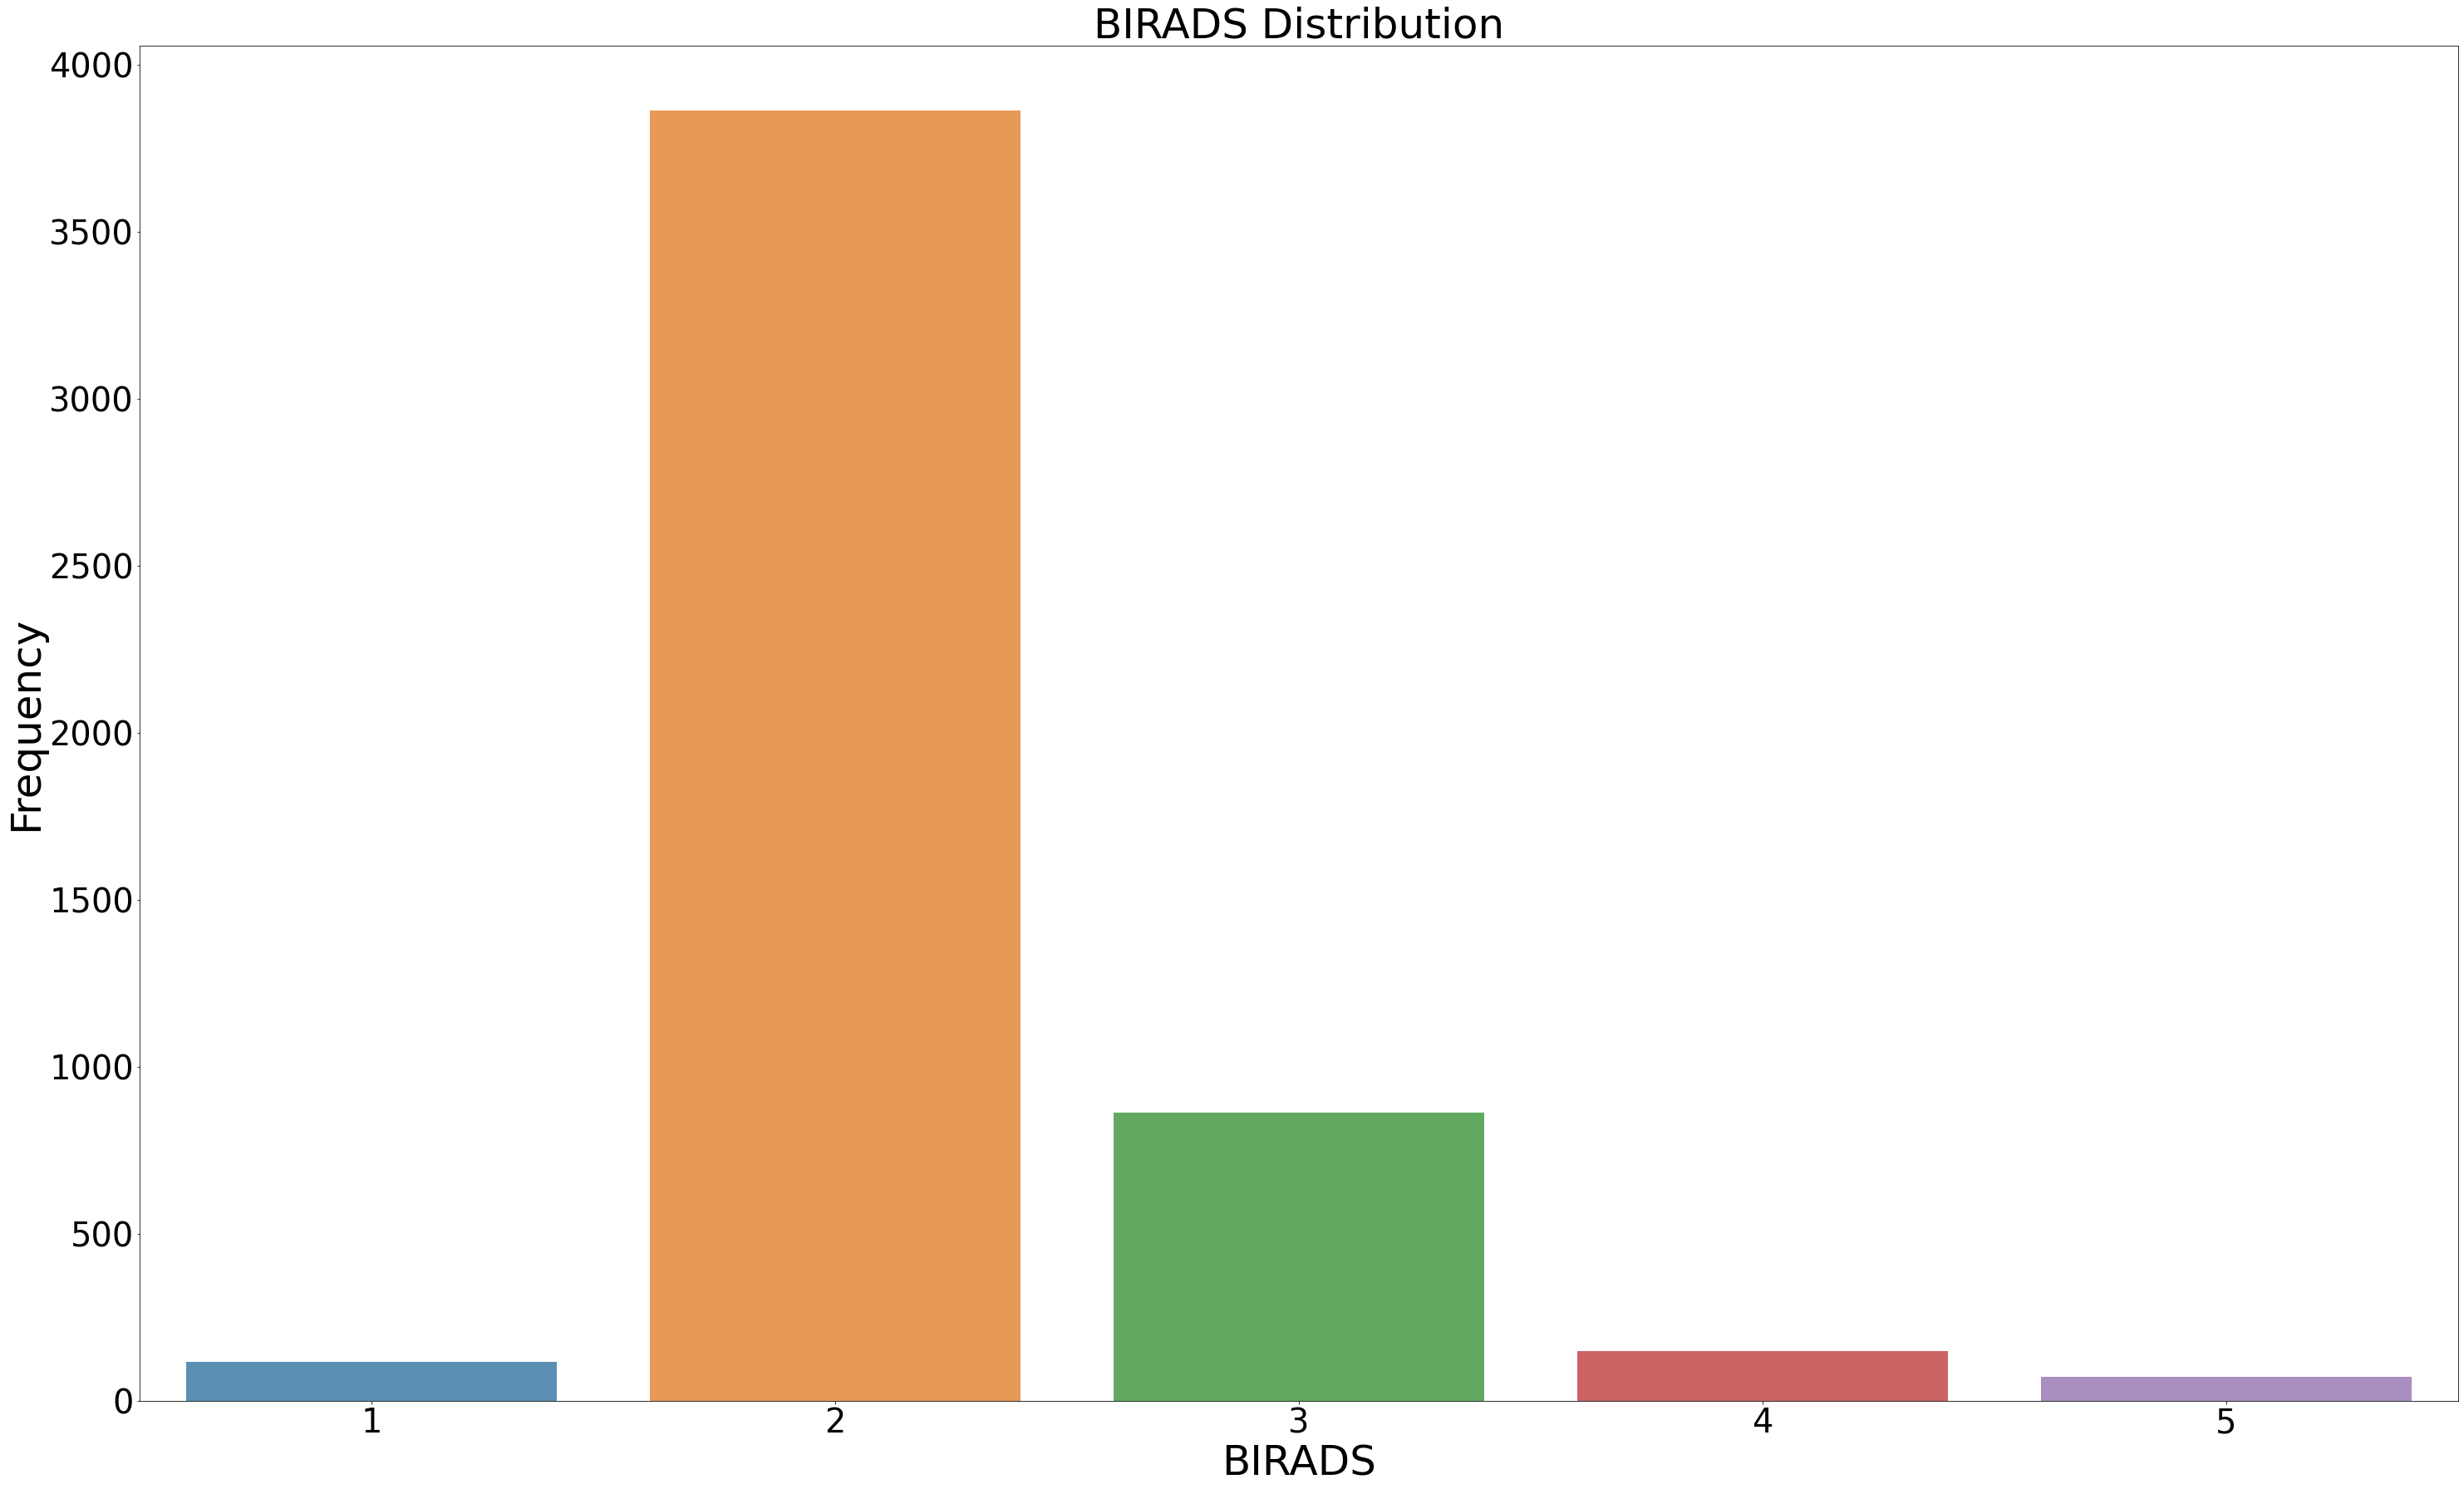

In [ ]:
#BIRADS Distribution Plot
x_rating = df.BIRADS.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("BIRADS Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('BIRADS', fontsize=50)
plt.xticks(fontsize=40)

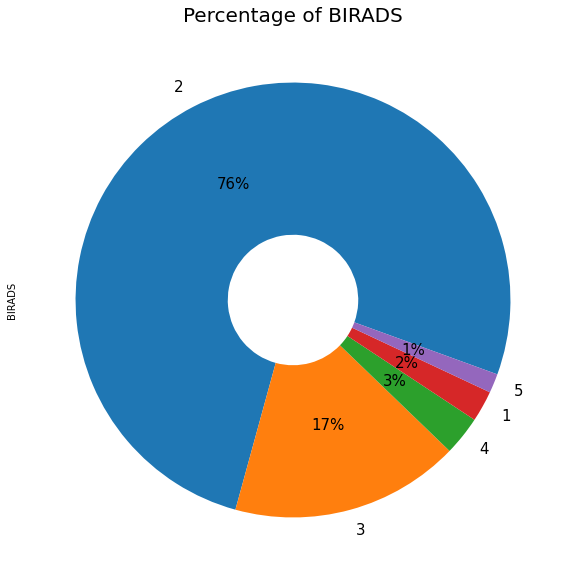

In [ ]:
#BIRADS distribution by percentage
plt.figure(figsize=(30,10))
plt.title('Percentage of BIRADS', fontsize=20)
df.BIRADS.value_counts().plot(kind='pie', labels=['2', '3', '4', '1', '5'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20,
                              textprops={'fontsize': 15})

In [ ]:
df['word_count'] = df['preprocessed_txt'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['preprocessed_txt'].astype(str).apply(len)
df.preprocessed_txt

0       Digital Mammography Tomosynthesis Bilateral Br...
1       Digital Mammography Tomosynthesis 3D Bilateral...
2       Digital Mammography Tomosynthesis 3D Bilateral...
3       Digital Mammography Tomosynthesis 3D Bilateral...
4       Digital Mammography Tomosynthesis 3D Bilateral...
                              ...                        
5060    Digital Mammography Tomosynthesis Bilateral Br...
5061    Digital Mammography Tomosynthesis 3D Bilateral...
5062    Digital Mammography Tomosynthesis Bilateral Br...
5063    Digital Mammography Tomosynthesis Bilateral Br...
5064    Digital Mammography Tomosynthesis 3D Bilateral...
Name: preprocessed_txt, Length: 5065, dtype: object

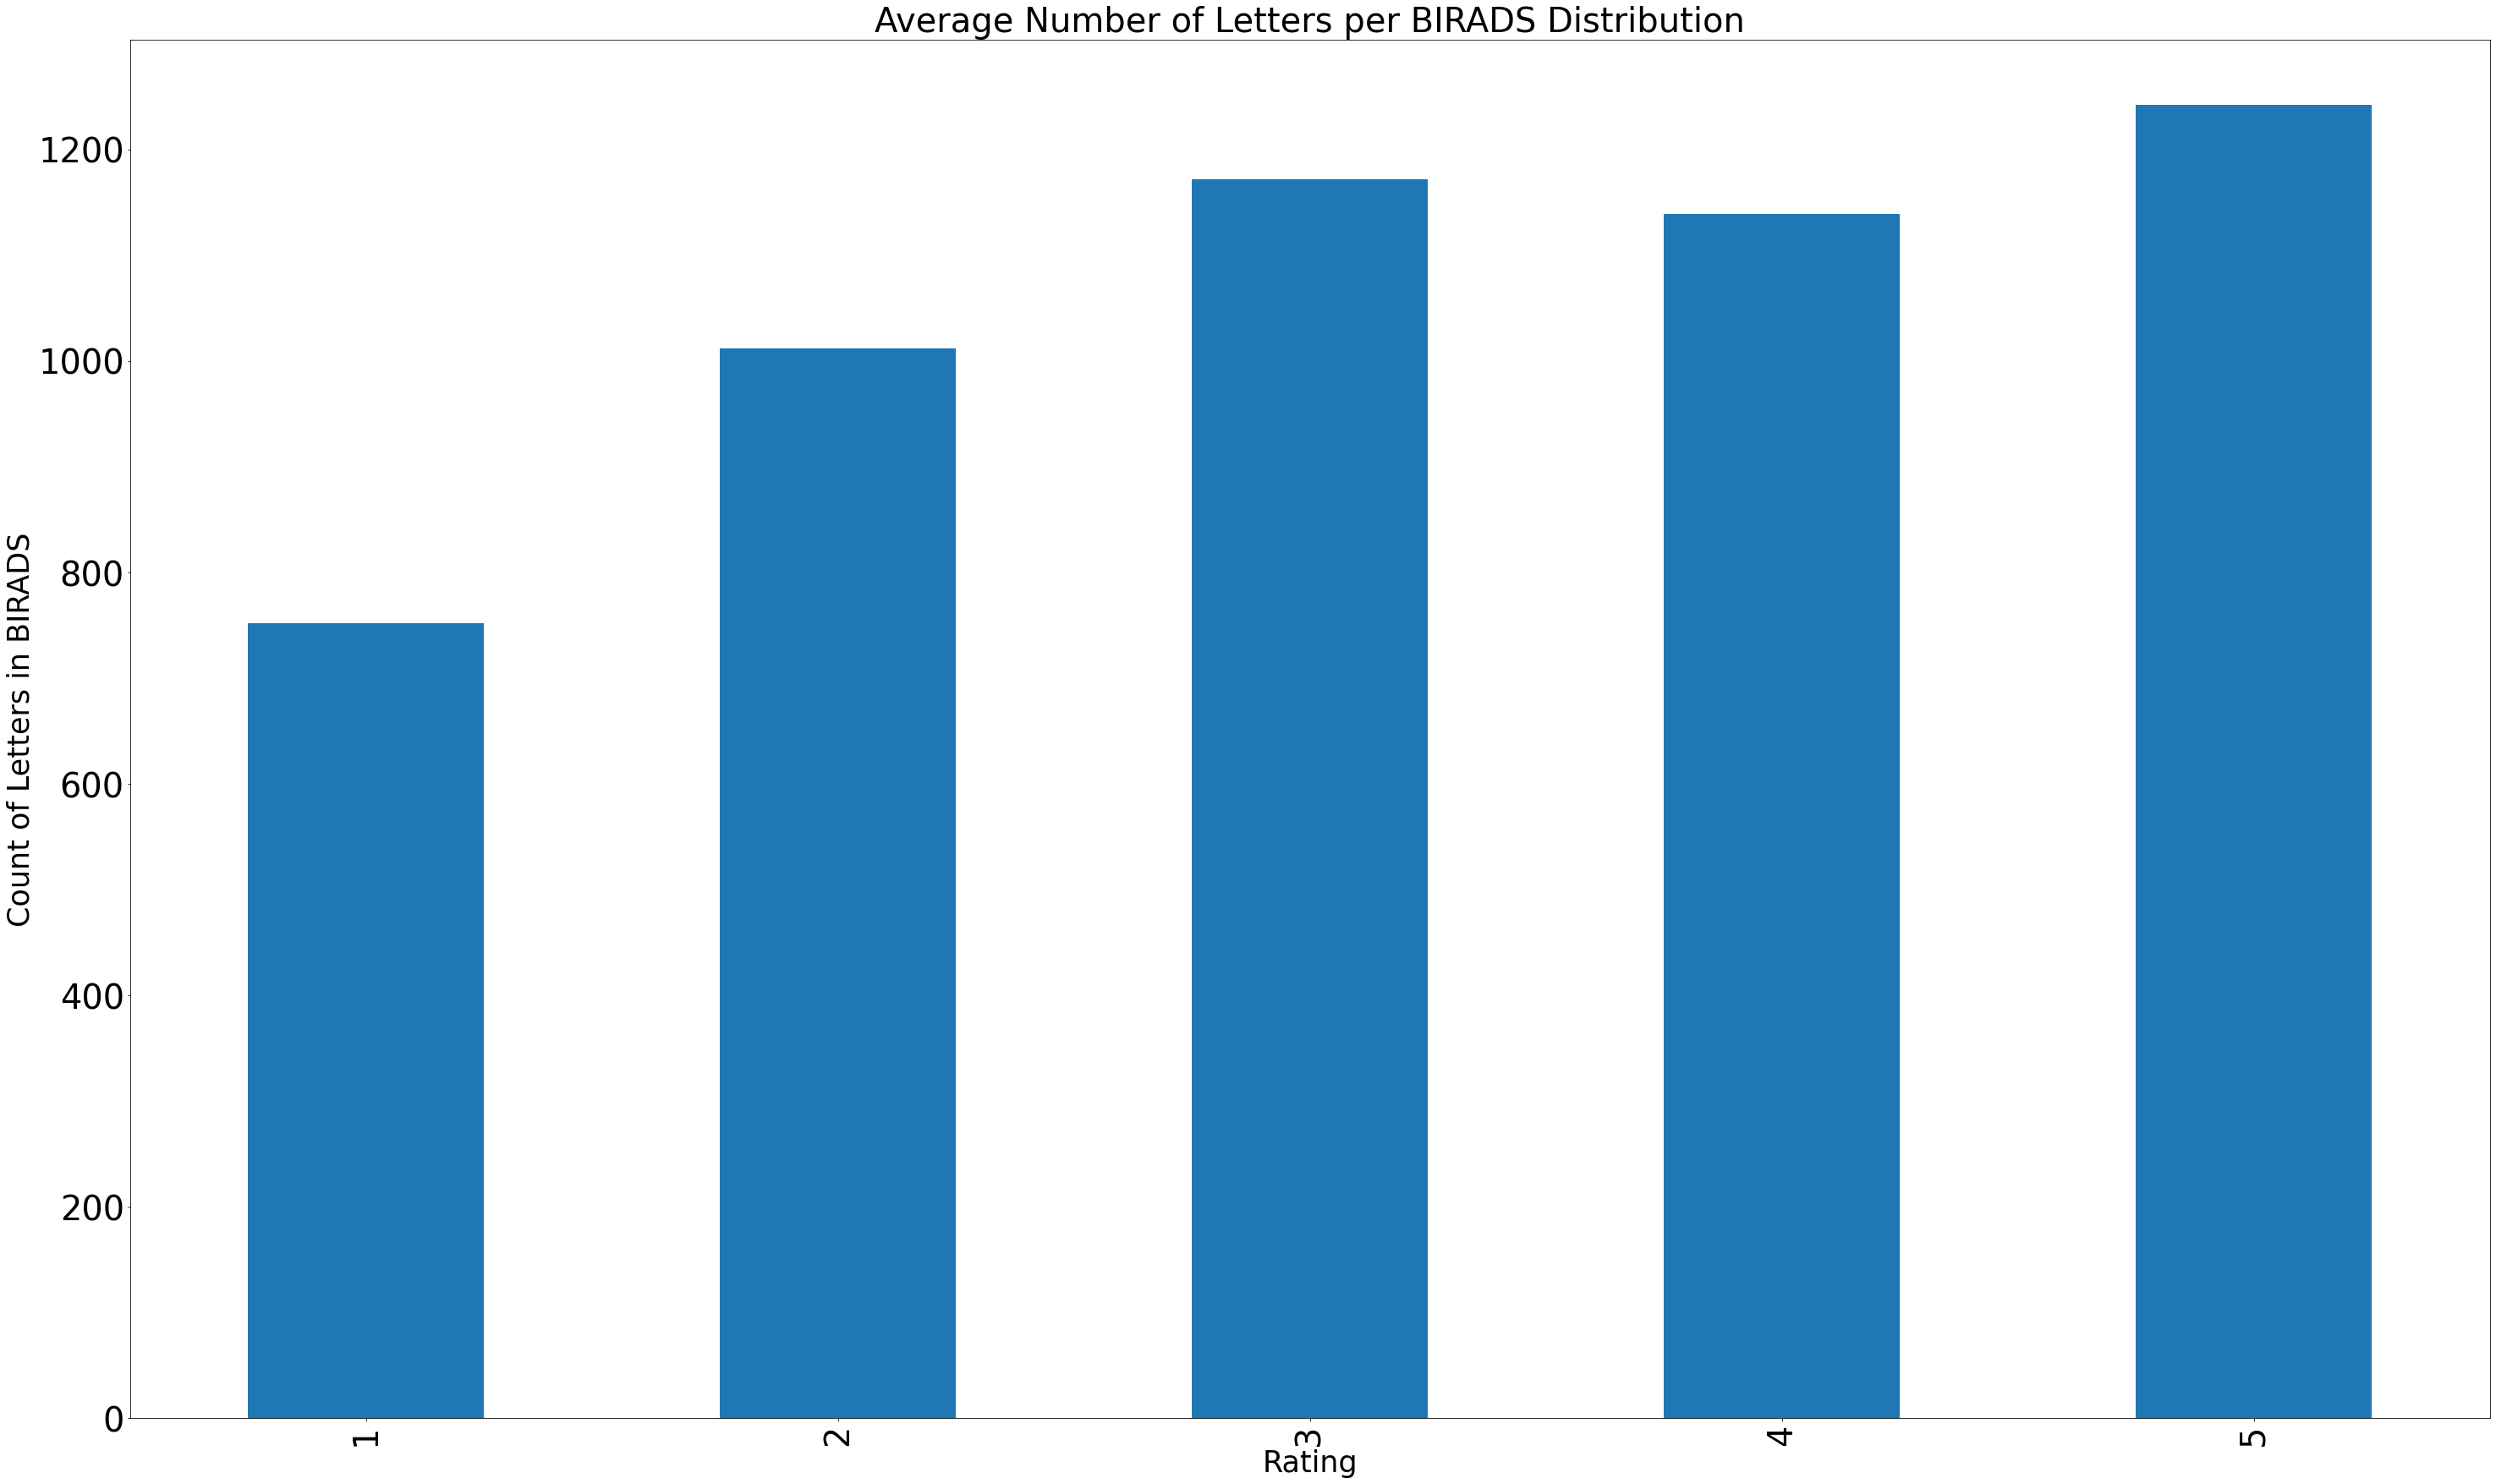

In [ ]:
letter_avg = df.groupby('BIRADS')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in BIRADS', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per BIRADS Distribution', fontsize=40)
plt.show()


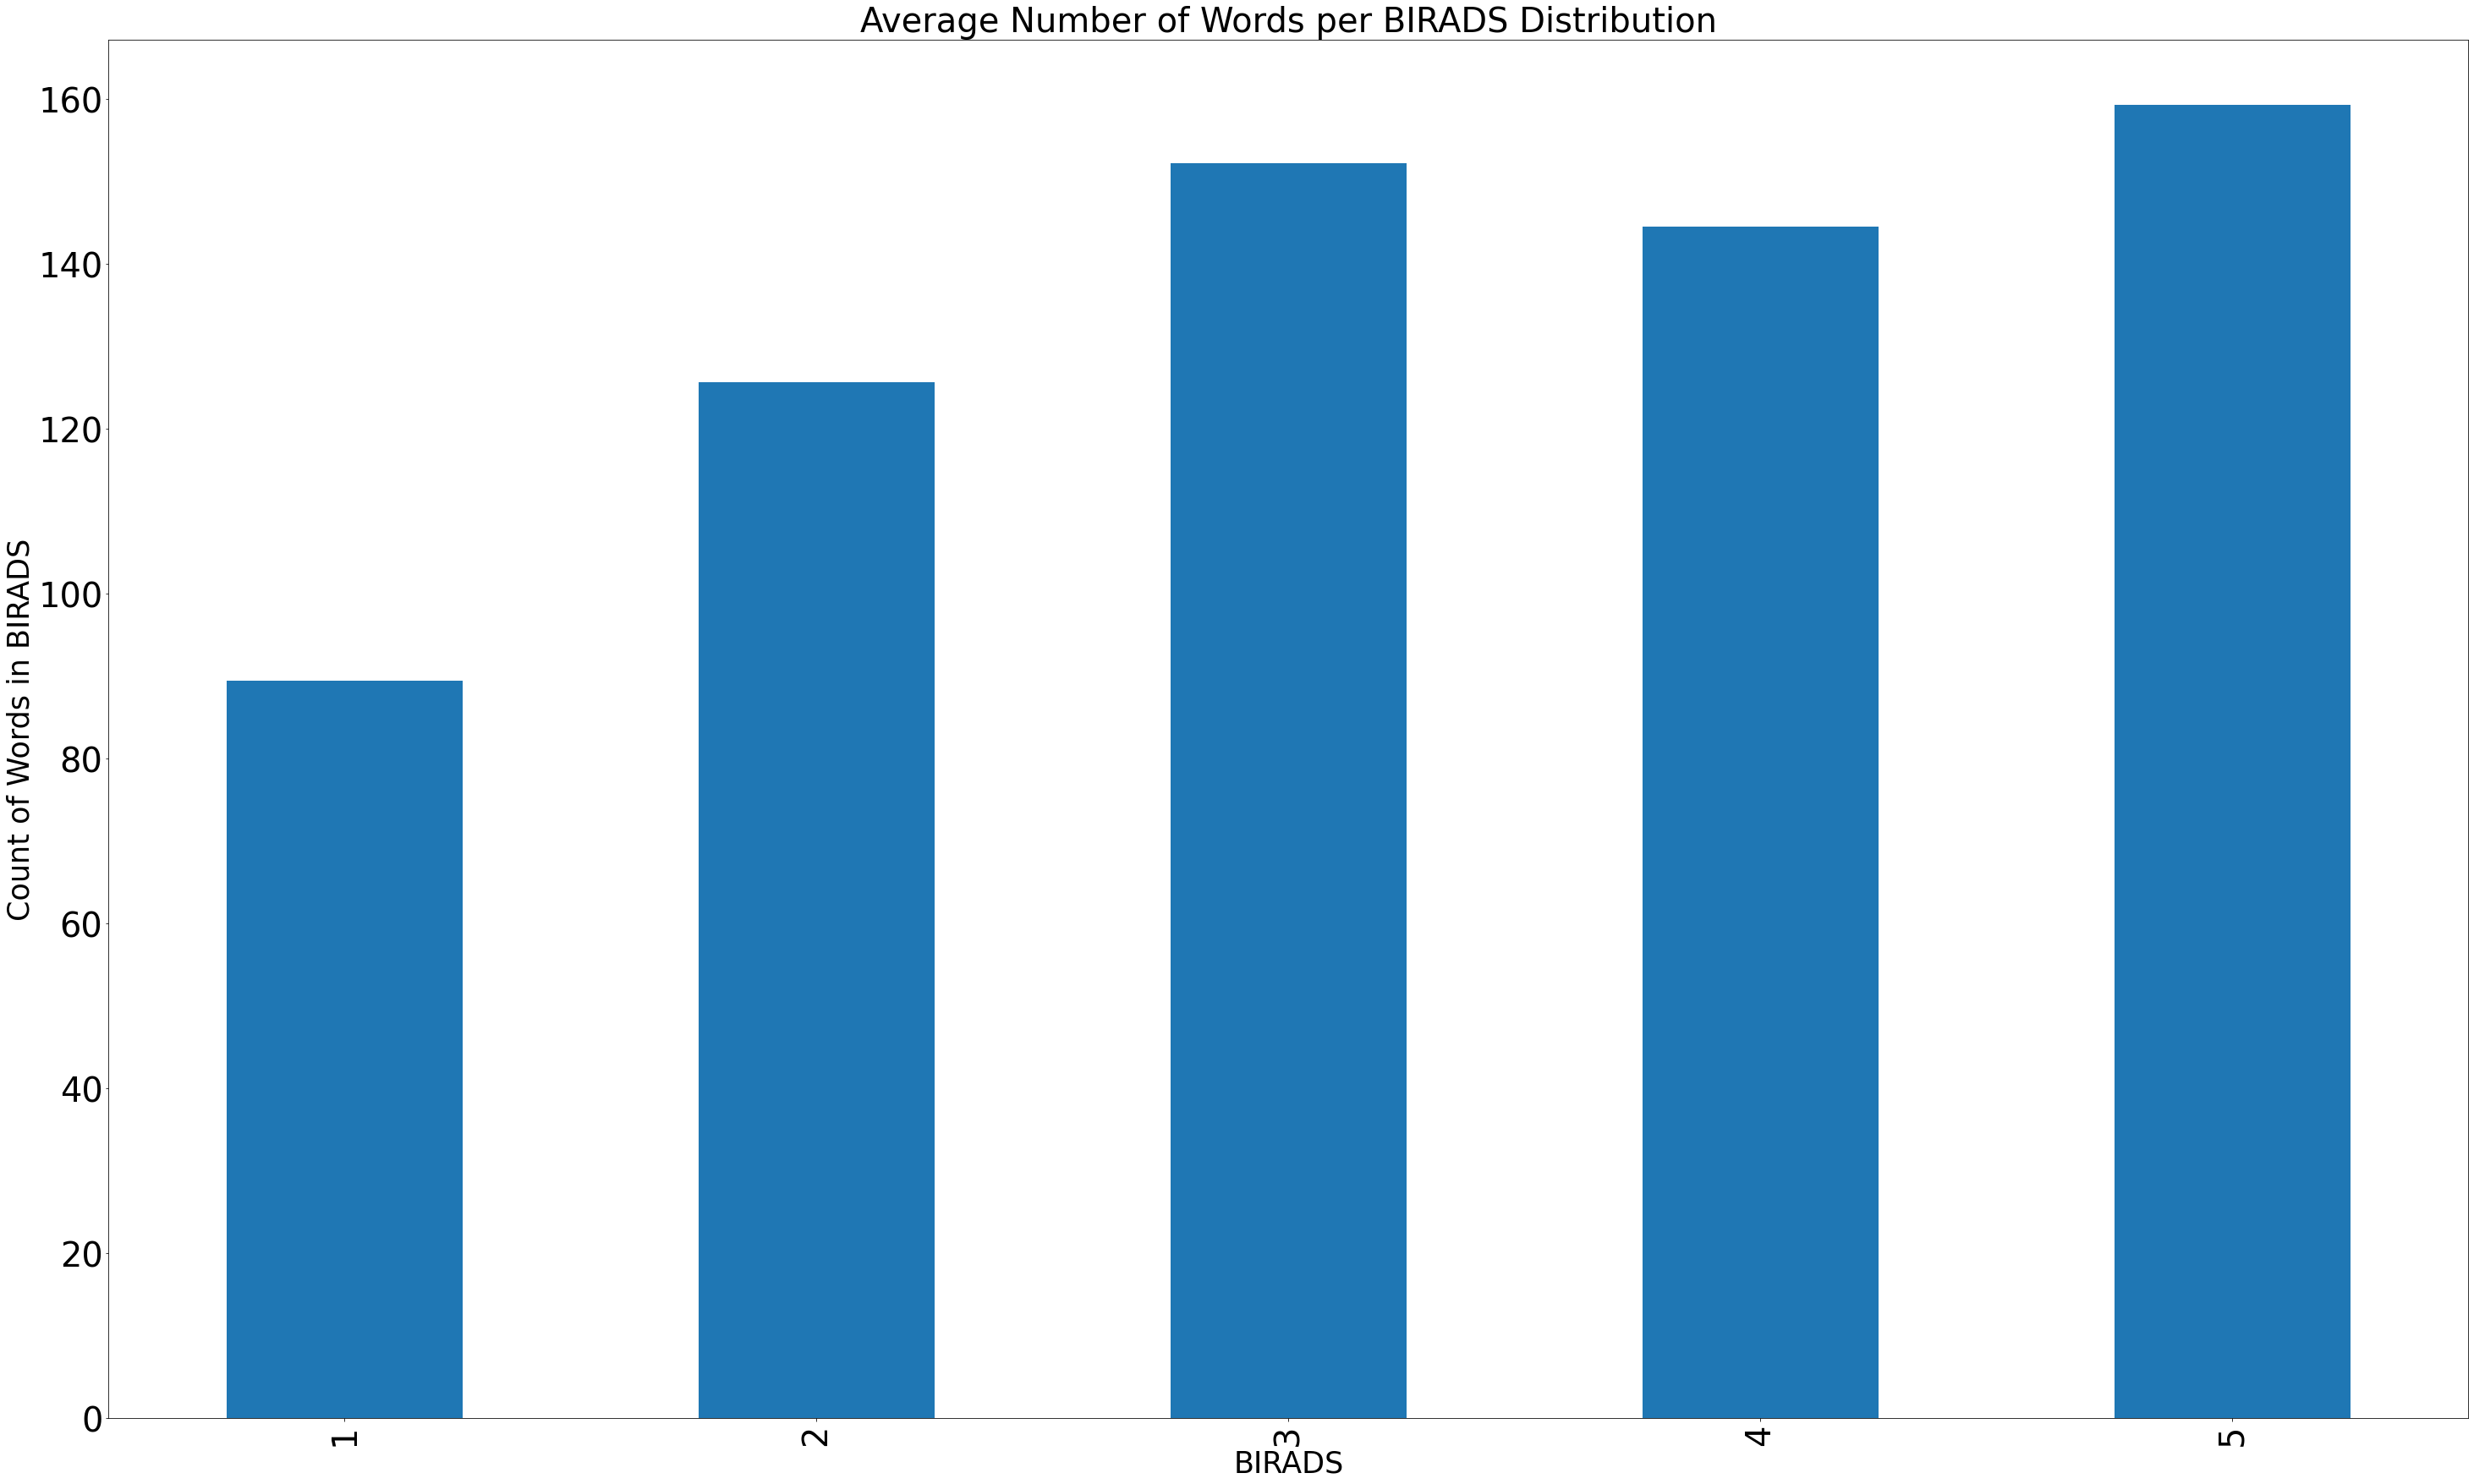

Report  BIRADS  \
0     Digital Mammography, Tomosynthesis and Bilater...       2   
1     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
2     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
3     Digital Mammography with Tomosynthesis (3D) an...       3   
4     Digital Mammography, Tomosynthesis (3D) and Bi...       2   
...                                                 ...     ...   
5060  Digital Mammography, Tomosynthesis and Bilater...       2   
5061  Digital Mammography, Tomosynthesis (3D) and Bi...       3   
5062  Digital Mammography, Tomosynthesis and Bilater...       2   
5063  Digital Mammography, Tomosynthesis and Bilater...       3   
5064  Digital Mammography, Tomosynthesis (3D) and Bi...       2   

                                       preprocessed_txt  word_count  \
0     Digital Mammography Tomosynthesis Bilateral Br...         111   
1     Digital Mammography Tomosynthesis 3D Bilateral...          94   
2     Digital Mammography Tomosynthesis 3D Bilateral...         139   
3     Digital Mammography Tomosynthesis 3D Bilateral...         109   
4     Digital Mammography Tomosynthesis 3D Bilateral...         134   
...                                                 ...         ...   
5060  Digital Mammography Tomosynthesis Bilateral Br...         145   
5061  Digital Mammography Tomosynthesis 3D Bilateral...         123   
5062  Digital Mammography Tomosynthesis Bilateral Br...         176   
5063  Digital Mammography Tomosynthesis Bilateral Br...         332   
5064  Digital Mammography Tomosynthesis 3D Bilateral...         152   

      review_len  
0            951  
1            815  
2           1131  
3            863  
4           1074  
...          ...  
5060        1185  
5061         971  
5062        1377  
5063        2350  
5064        1097  

[5065 rows x 5 columns]

In [ ]:
word_avg = df.groupby('BIRADS')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('BIRADS', fontsize=35)
plt.ylabel('Count of Words in BIRADS', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per BIRADS Distribution', fontsize=40)
plt.show()
df

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

words = df['preprocessed_txt']

allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
all_headlines = ' '.join(df['preprocessed_txt'].str.lower())

In [ ]:
all_headlines

"digital mammography tomosynthesis bilateral breast ultrasounda indication routine study asymptomatic 55 year old patient technique conventional mammography projection tomosynthesis 3d bilateral breast ultrasound perform compare previous study institution 2011 2013 finding breast tissue characterize scatter area fibroglandular density pattern b american college radiology acr 2013 .a left breast asymmetry observe visualize oblique projection upper quadrant disappear lateral projection suggest arthroplasty summation glandular tissue masse new density calcification suspicious malignancy observe bilateral isolated punctate calcification observe tomosynthesis additional finding ultrasound perform identify echogenic homogeneous breast tissue respected architecture find solid mass right breast isolated microcyst axillary node normal conclusion   2 finding benign study negative malignancy    absence palpable finding annual routine study recommend digital mammography tomosynthesis 3d bilateral 

In [ ]:
stopwords = STOPWORDS
stopwords.add('will')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(all_headlines)


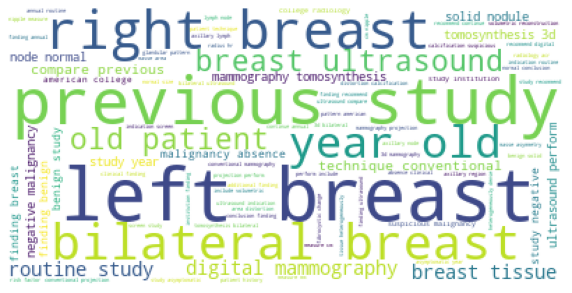

In [ ]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
filtered_words = [word for word in all_headlines.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

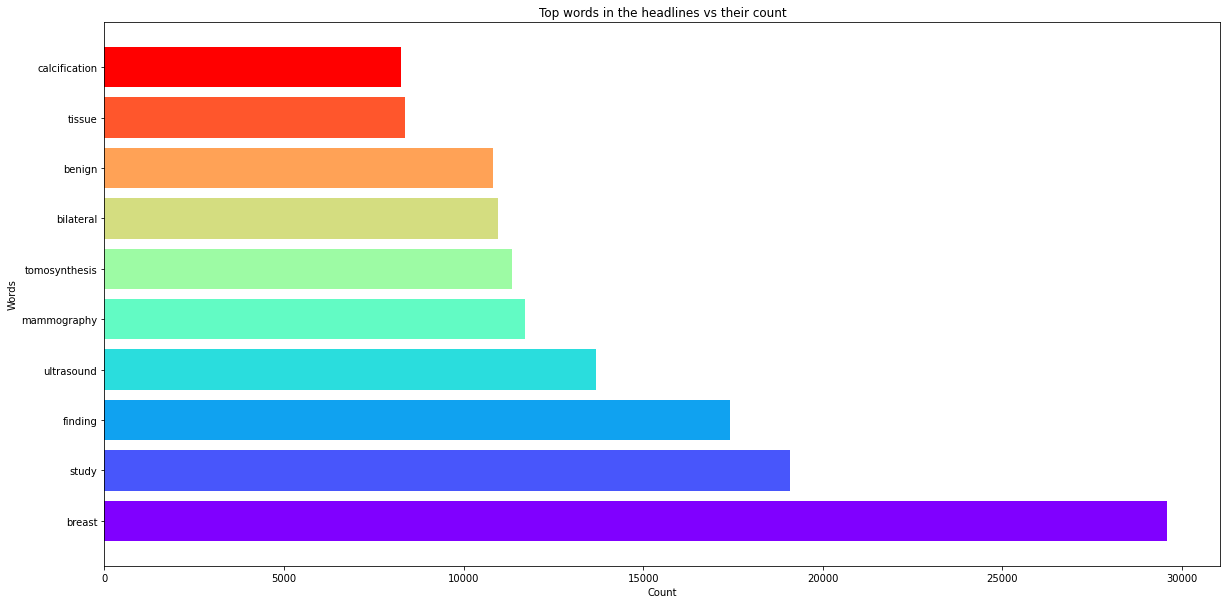

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

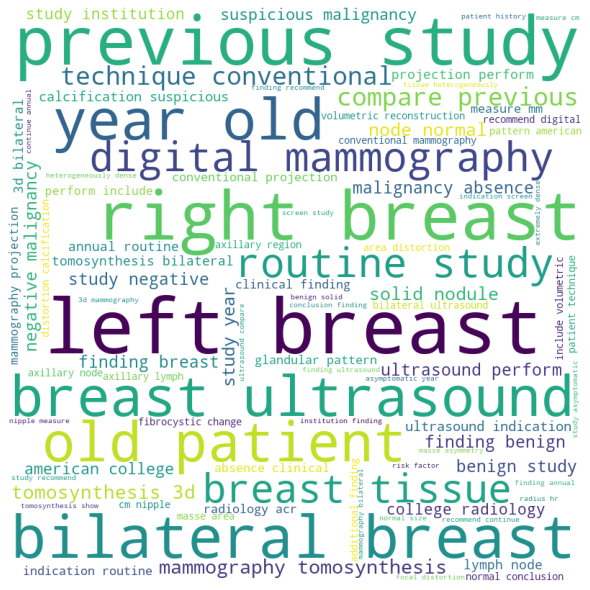

In [ ]:
# Word cloud


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.preprocessed_txt:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

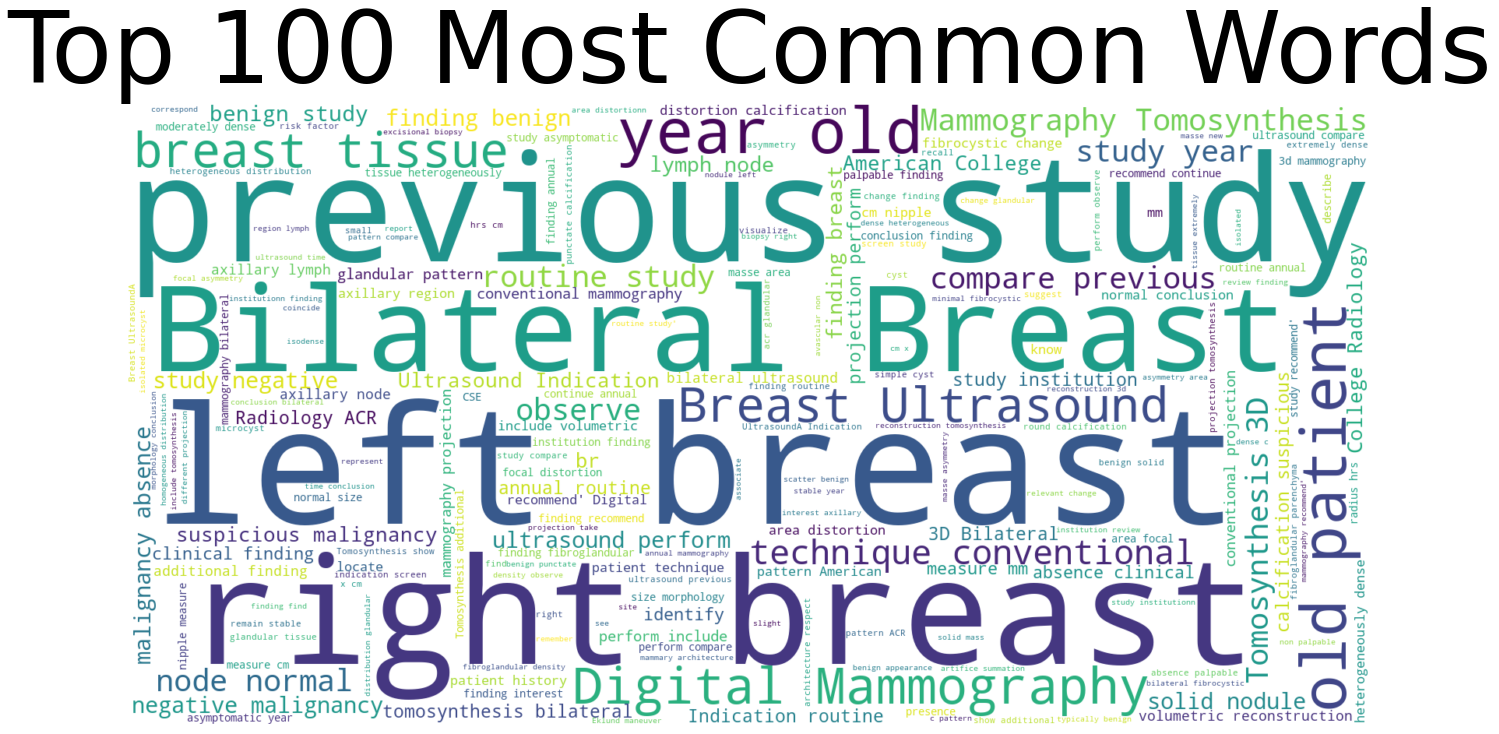

In [ ]:
# 100 most common words
mostcommon = FreqDist(df.preprocessed_txt).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

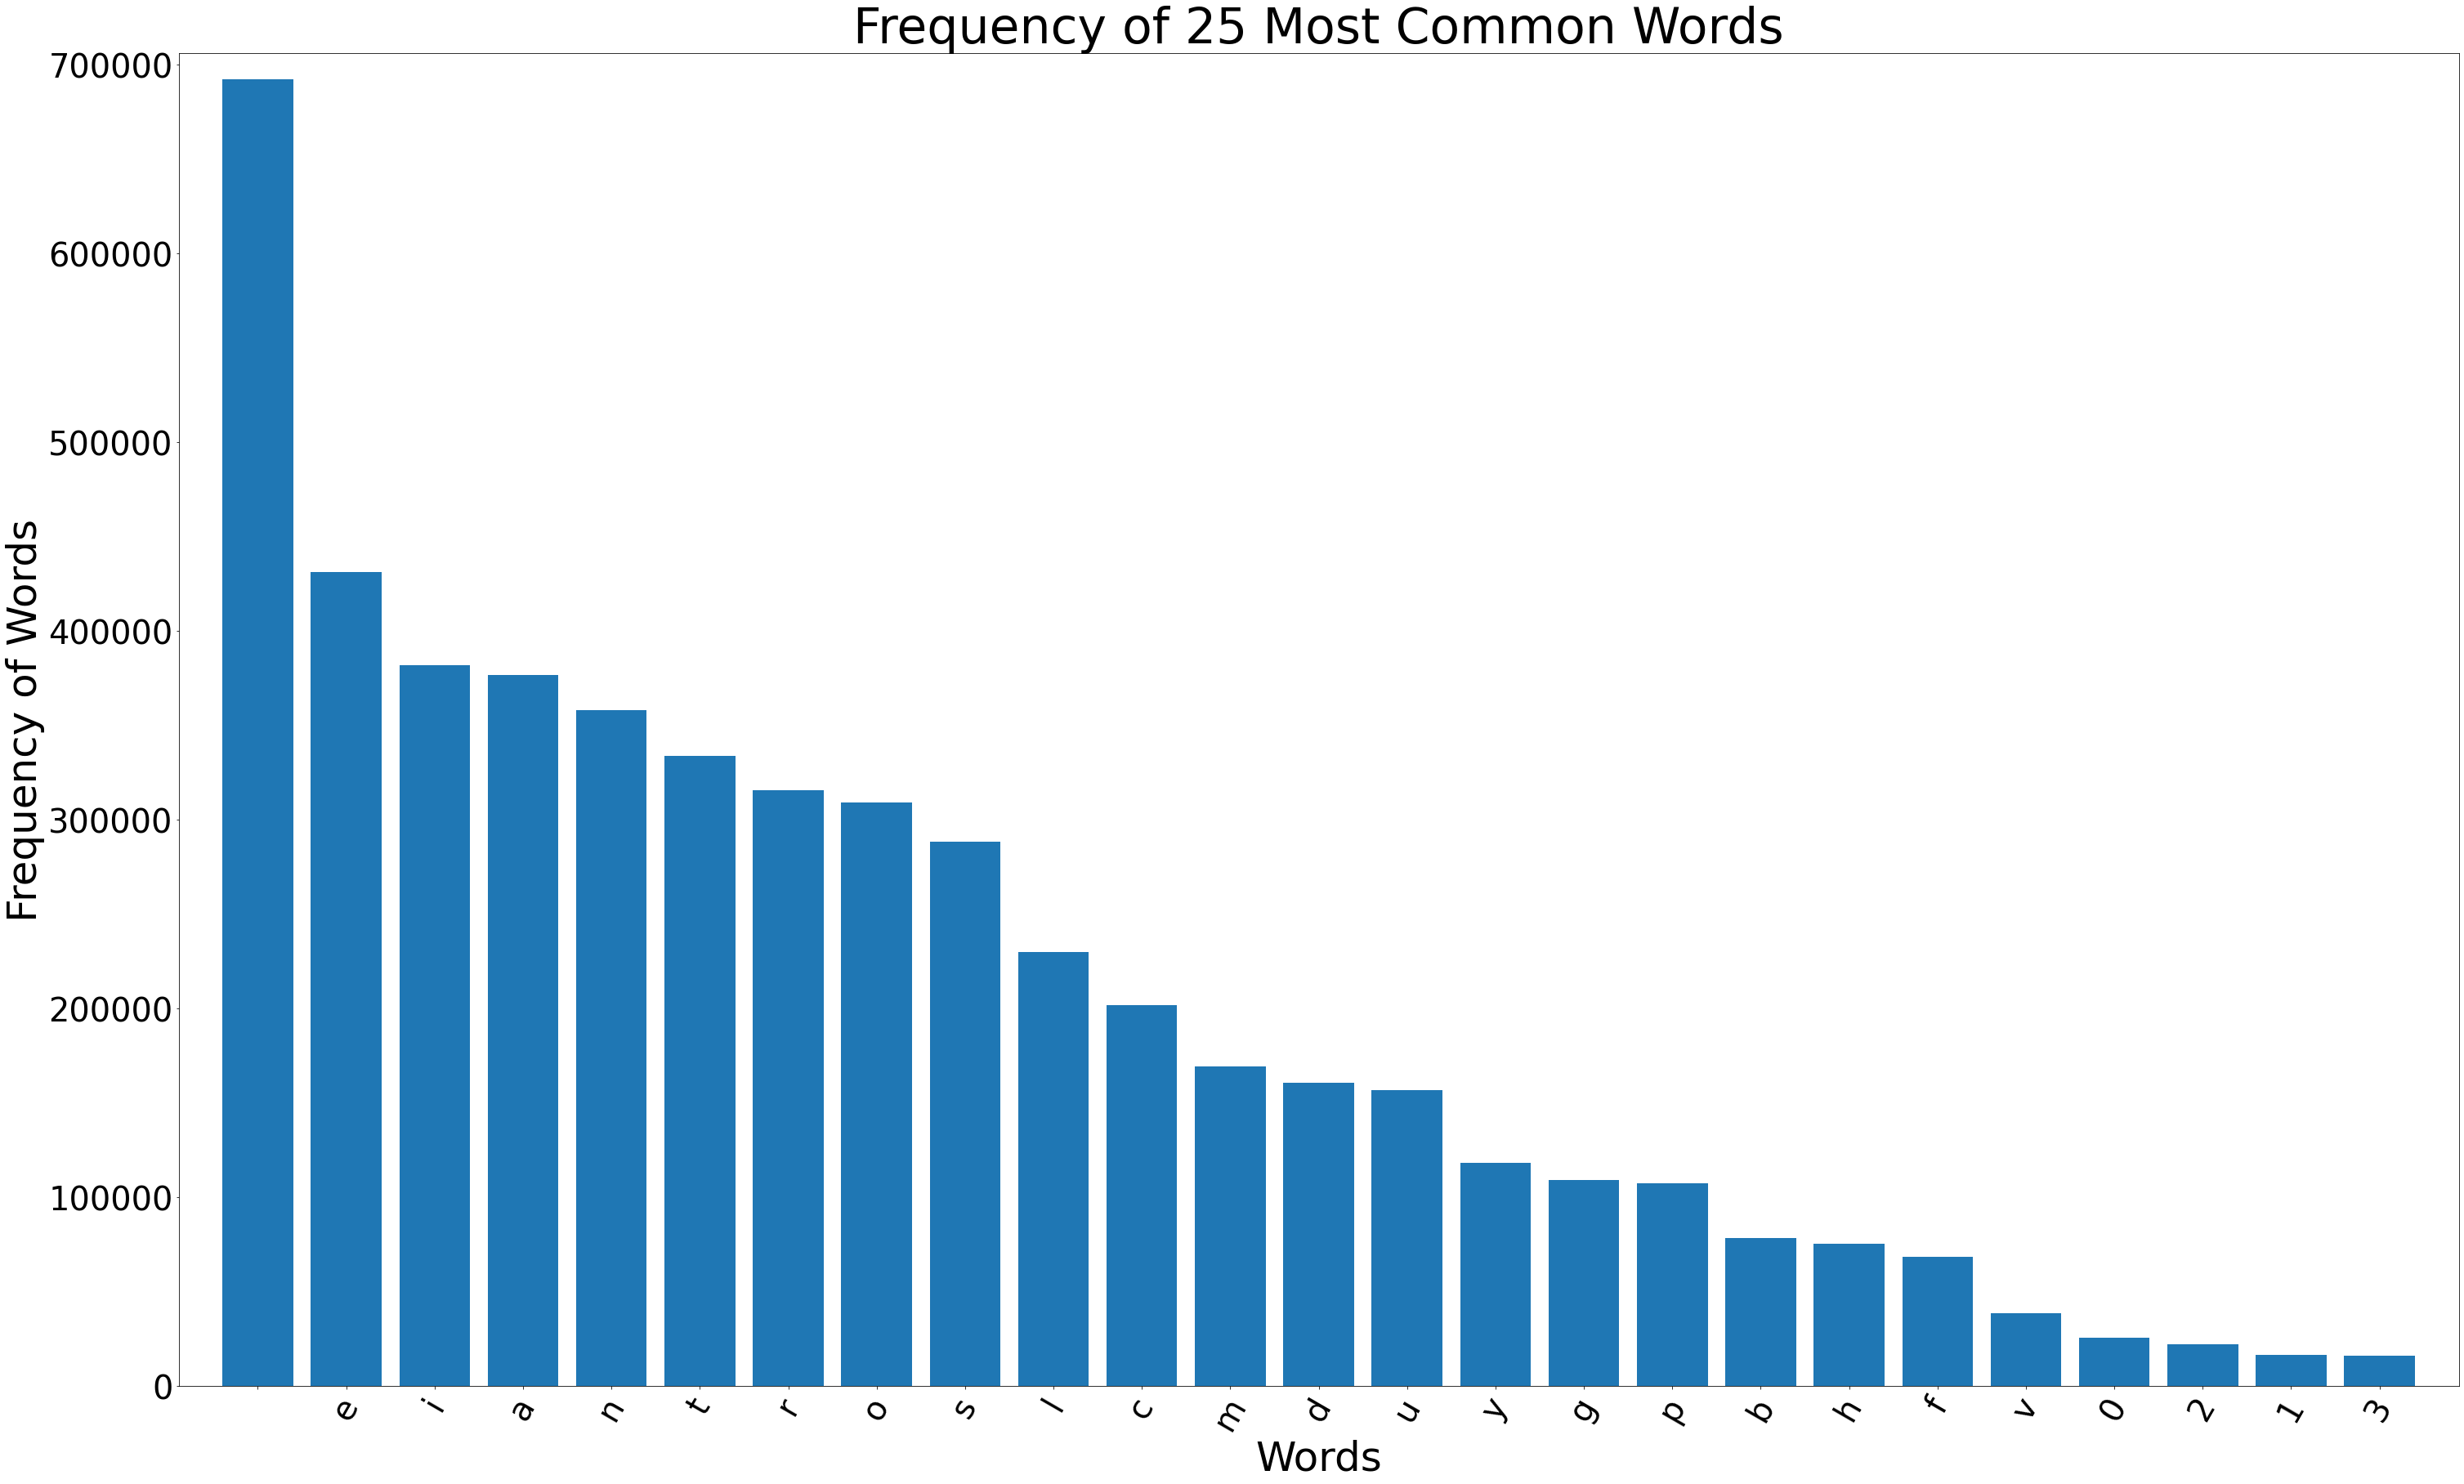

In [ ]:
# 25 Most common words

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

In [ ]:
#check the distribution of labels
df['BIRADS'].value_counts()

2    3864
3     864
4     148
1     117
5      72
Name: BIRADS, dtype: int64

In [ ]:

bng = pyproj.Proj(init='epsg:27700')
wgs84 = pyproj.Proj(init='epsg:4326')

east = 502207
north = 305584

lat, lon = pyproj.transform(bng, wgs84, east, north)

print (lon, lat)

52.63838623001269 -0.4910535492725081


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-5-c3e04c26dbc2>:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat, lon = pyproj.transform(bng, wgs84, east, no

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.Report,
    df.BIRADS,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.BIRADS
)

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4052,)
Shape of X_test:  (1013,)


In [ ]:

# TF-IDF Vectorizer & KNN

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('KNN', KNeighborsClassifier())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))
#print(TfidfVectorizer)

              precision    recall  f1-score   support

           1       1.00      0.04      0.08        23
           2       0.87      1.00      0.93       773
           3       0.91      0.56      0.69       173
           4       0.71      0.17      0.27        30
           5       0.92      0.86      0.89        14

    accuracy                           0.87      1013
   macro avg       0.88      0.52      0.57      1013
weighted avg       0.88      0.87      0.85      1013



In [ ]:
# TF-IDF Vectorizer & SVM
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('SVM', svm.SVC())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))
#print(TfidfVectorizer)

              precision    recall  f1-score   support

           1       1.00      0.17      0.30        23
           2       0.95      1.00      0.98       773
           3       0.96      0.91      0.94       173
           4       0.82      0.60      0.69        30
           5       1.00      0.79      0.88        14

    accuracy                           0.95      1013
   macro avg       0.95      0.69      0.76      1013
weighted avg       0.95      0.95      0.94      1013



In [ ]:
# TF-IDF Vectorizer & MNB


#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.82      1.00      0.90       773
           3       0.74      0.28      0.41       173
           4       0.50      0.07      0.12        30
           5       0.00      0.00      0.00        14

    accuracy                           0.81      1013
   macro avg       0.41      0.27      0.29      1013
weighted avg       0.77      0.81      0.76      1013



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# TF-IDF Vectorizer & RF

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),        #using the ngram_range parameter
     ('Random Forest', RandomForestClassifier())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.22      0.36        23
           2       0.95      1.00      0.98       773
           3       0.96      0.93      0.94       173
           4       0.78      0.47      0.58        30
           5       1.00      0.71      0.83        14

    accuracy                           0.95      1013
   macro avg       0.94      0.67      0.74      1013
weighted avg       0.95      0.95      0.94      1013



In [ ]:

# TF-IDF Vectorizer & AdaBoost

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('AdaBoost', AdaBoostClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.04      0.48      0.08        23
           2       0.96      0.66      0.78       773
           3       0.71      0.93      0.81       173
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        14

    accuracy                           0.67      1013
   macro avg       0.34      0.41      0.33      1013
weighted avg       0.85      0.67      0.73      1013



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:


# TF-IDF Vectorizer & GB

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('GradientBoost', GradientBoostingClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.83      0.88        23
           2       0.98      1.00      0.99       773
           3       0.96      0.94      0.95       173
           4       0.91      0.70      0.79        30
           5       0.92      0.86      0.89        14

    accuracy                           0.97      1013
   macro avg       0.95      0.86      0.90      1013
weighted avg       0.97      0.97      0.97      1013



In [ ]:

# TF-IDF Vectorizer & XGB

xg = xgb.XGBClassifier()

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('XGB', xgb.XGBClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.78      0.86        23
           2       0.98      1.00      0.99       773
           3       0.96      0.94      0.95       173
           4       0.85      0.73      0.79        30
           5       0.91      0.71      0.80        14

    accuracy                           0.97      1013
   macro avg       0.93      0.83      0.88      1013
weighted avg       0.97      0.97      0.97      1013



In [ ]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(df):
    # remove stop words and lemmatize the text
    doc = nlp(df)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
df['preprocessed_txt'] = df['Report'].apply(preprocess)

In [ ]:
df.head()

Report  BIRADS  \
0  Digital Mammography, Tomosynthesis and Bilater...       2   
1  Digital Mammography, Tomosynthesis (3D) and Bi...       2   
2  Digital Mammography, Tomosynthesis (3D) and Bi...       2   
3  Digital Mammography with Tomosynthesis (3D) an...       3   
4  Digital Mammography, Tomosynthesis (3D) and Bi...       2   

                                    preprocessed_txt  
0  Digital Mammography Tomosynthesis Bilateral Br...  
1  Digital Mammography Tomosynthesis 3D Bilateral...  
2  Digital Mammography Tomosynthesis 3D Bilateral...  
3  Digital Mammography Tomosynthesis 3D Bilateral...  
4  Digital Mammography Tomosynthesis 3D Bilateral...

In [ ]:
df.Report[0]

'Digital Mammography, Tomosynthesis and Bilateral Breast UltrasoundA Indication: Routine study in asymptomatic 55-year-old patient.A Technique: Conventional mammography projections, tomosynthesis (3D) and bilateral breast ultrasound are performed. It is compared with previous studies from this institution (2011 and 2013). Findings:A Breast tissue is characterized by scattered areas of fibroglandular density (pattern "b" of the American College of Radiology, ACR 2013) .A In the left breast, an asymmetry is observed, visualized only in the oblique projection, towards the upper quadrants, which disappears in the lateral projection, suggesting an arthroplasty due to the summation of glandular tissue. There are no masses , or new densities. Neither are calcifications suspicious for malignancy observed. Bilateral isolated punctate calcifications are observed.A Tomosynthesis did not show additional findings.A Ultrasound is performed, identifying echogenic and homogeneous breast tissue with re

In [ ]:
df.preprocessed_txt[0]

'Digital Mammography Tomosynthesis Bilateral Breast UltrasoundA Indication routine study asymptomatic 55 year old patient technique conventional mammography projection tomosynthesis 3D bilateral breast ultrasound perform compare previous study institution 2011 2013 finding breast tissue characterize scatter area fibroglandular density pattern b American College Radiology ACR 2013 .A left breast asymmetry observe visualize oblique projection upper quadrant disappear lateral projection suggest arthroplasty summation glandular tissue masse new density calcification suspicious malignancy observe bilateral isolated punctate calcification observe Tomosynthesis additional finding Ultrasound perform identify echogenic homogeneous breast tissue respected architecture find solid mass right breast isolated microcyst axillary node normal conclusion   2 finding benign study negative malignancy    absence palpable finding annual routine study recommend'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.preprocessed_txt,
    df.BIRADS,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.BIRADS
)


In [ ]:
#KNN_preprocess

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('KNN', KNeighborsClassifier())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))
#print(TfidfVectorizer)

              precision    recall  f1-score   support

           1       0.50      0.17      0.26        23
           2       0.90      0.99      0.95       773
           3       0.89      0.68      0.77       173
           4       0.80      0.27      0.40        30
           5       0.85      0.79      0.81        14

    accuracy                           0.90      1013
   macro avg       0.79      0.58      0.64      1013
weighted avg       0.89      0.90      0.88      1013



In [ ]:
#SVM_preprocess


clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('SVM', svm.SVC())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))
#print(TfidfVectorizer)

              precision    recall  f1-score   support

           1       1.00      0.13      0.23        23
           2       0.95      1.00      0.98       773
           3       0.96      0.91      0.94       173
           4       0.83      0.63      0.72        30
           5       1.00      0.79      0.88        14

    accuracy                           0.95      1013
   macro avg       0.95      0.69      0.75      1013
weighted avg       0.95      0.95      0.94      1013



In [ ]:
#NB_preprocess
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        23
           2       0.86      1.00      0.92       773
           3       0.80      0.52      0.63       173
           4       0.50      0.07      0.12        30
           5       0.00      0.00      0.00        14

    accuracy                           0.85      1013
   macro avg       0.43      0.32      0.33      1013
weighted avg       0.81      0.85      0.82      1013



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#RF_Preprocess

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),        #using the ngram_range parameter
     ('Random Forest', RandomForestClassifier())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.13      0.23        23
           2       0.96      1.00      0.98       773
           3       0.95      0.92      0.94       173
           4       0.87      0.67      0.75        30
           5       1.00      0.79      0.88        14

    accuracy                           0.95      1013
   macro avg       0.95      0.70      0.76      1013
weighted avg       0.95      0.95      0.95      1013



In [ ]:
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('AdaBoost', AdaBoostClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.04      0.48      0.07        23
           2       0.96      0.61      0.75       773
           3       0.71      0.93      0.81       173
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        14

    accuracy                           0.64      1013
   macro avg       0.34      0.40      0.32      1013
weighted avg       0.85      0.64      0.71      1013



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('GradientBoost', GradientBoostingClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.83      0.88        23
           2       0.98      1.00      0.99       773
           3       0.96      0.93      0.94       173
           4       0.88      0.70      0.78        30
           5       0.83      0.71      0.77        14

    accuracy                           0.97      1013
   macro avg       0.92      0.83      0.87      1013
weighted avg       0.97      0.97      0.97      1013



In [ ]:
import xgboost as xgb

xg = xgb.XGBClassifier()

clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('XGB', xgb.XGBClassifier())
])


clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.74      0.83        23
           2       0.98      1.00      0.99       773
           3       0.96      0.93      0.95       173
           4       0.85      0.77      0.81        30
           5       0.92      0.79      0.85        14

    accuracy                           0.97      1013
   macro avg       0.93      0.84      0.88      1013
weighted avg       0.97      0.97      0.97      1013

